# Feature-Level Analysis: Elliptic Bitcoin Dataset

**Objective:** Identify the most predictive features and validate Weber et al. (2019) finding that Aggregated Features > Local Features

**Key Questions:**
1. Which features are most important for fraud detection?
2. Do aggregated features outperform local features?
3. Are there highly correlated features (multicollinearity)?
4. Which features show strongest class separation (illicit vs licit)?

**Dataset:**
- 166 features total
- Local features (1-94): Transaction-specific attributes
- Aggregated features (95-166): Neighbor statistics from 1-hop aggregation

---
## Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load data
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv")

print(f"Classes: {classes_df.shape}")
print(f"Features: {features_df.shape}")

Classes: (203769, 2)
Features: (203768, 167)


In [3]:
# Prepare data
node_ids = features_df.iloc[:, 0].values
time_steps = features_df.iloc[:, 1].values
X = features_df.iloc[:, 2:].values  # 166 features (excluding ID and time step)

# Map labels: '1'=illicit, '2'=licit, 'unknown'=unlabeled
label_map = dict(zip(classes_df['txId'], classes_df['class']))
labels = np.array([label_map.get(nid, 'unknown') for nid in node_ids])

# Filter to labeled data only
labeled_mask = (labels == '1') | (labels == '2')
X_labeled = X[labeled_mask]
y_labeled = (labels[labeled_mask] == '1').astype(int)  # 1=illicit, 0=licit

print(f"\nTotal nodes: {len(node_ids):,}")
print(f"Labeled nodes: {labeled_mask.sum():,}")
print(f"  Illicit: {y_labeled.sum():,} ({y_labeled.sum()/len(y_labeled)*100:.2f}%)")
print(f"  Licit: {(1-y_labeled).sum():,} ({(1-y_labeled).sum()/len(y_labeled)*100:.2f}%)")


Total nodes: 203,768
Labeled nodes: 46,564
  Illicit: 4,545 (9.76%)
  Licit: 42,019 (90.24%)


---
## Part 1: Feature Importance Analysis

Using XGBoost to determine which features are most predictive of fraud

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.3, random_state=42, stratify=y_labeled
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")

Training set: 32,594 samples
Test set: 13,970 samples


In [5]:
# Calculate class weight for imbalance handling
scale_pos_weight = (1 - y_train).sum() / y_train.sum()
print(f"Class imbalance ratio (licit/illicit): {scale_pos_weight:.2f}")

Class imbalance ratio (licit/illicit): 9.25


In [6]:
# Train XGBoost model
print("Training XGBoost model...")

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

print("Training complete!")

Training XGBoost model...
Training complete!


In [7]:
# Evaluate model performance
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")


Model Performance:
  Accuracy:  0.9874
  Precision: 0.9255
  Recall:    0.9472
  F1 Score:  0.9362


In [8]:
# Extract feature importance
feature_importance = xgb_model.feature_importances_

# Create DataFrame with feature metadata
importance_df = pd.DataFrame({
    'Feature_Index': range(len(feature_importance)),
    'Importance': feature_importance,
    'Feature_Type': ['Local' if i < 94 else 'Aggregated' for i in range(len(feature_importance))]
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))


Top 20 Most Important Features:
 Feature_Index  Importance Feature_Type
            89    0.091487        Local
            52    0.082325        Local
            58    0.081322        Local
           162    0.074799   Aggregated
            64    0.066005        Local
             4    0.048755        Local
            30    0.027276        Local
            40    0.017472        Local
            46    0.016382        Local
           160    0.015724   Aggregated
            57    0.013764        Local
           124    0.012898   Aggregated
            79    0.012870        Local
            16    0.012734        Local
            15    0.011937        Local
            45    0.011800        Local
            65    0.011341        Local
           135    0.011006   Aggregated
           151    0.010962   Aggregated
            76    0.010817        Local


In [9]:
# Analyze feature importance by type (Local vs Aggregated)
type_summary = importance_df.groupby('Feature_Type')['Importance'].agg(['sum', 'mean', 'count'])

print("\nFeature Importance by Type:")
print(type_summary)

local_importance = type_summary.loc['Local', 'mean']
aggregated_importance = type_summary.loc['Aggregated', 'mean']

print(f"\nAverage Importance:")
print(f"  Local Features (1-94):      {local_importance:.6f}")
print(f"  Aggregated Features (95-166): {aggregated_importance:.6f}")
print(f"  Ratio (Aggregated/Local):     {aggregated_importance/local_importance:.2f}x")

if aggregated_importance > local_importance:
    print("\n✓ VALIDATION: Aggregated Features > Local Features")
    print("  Confirms Weber et al. (2019) finding: AF > LF")
else:
    print("\n⚠ Result differs from Weber et al. (2019)")


Feature Importance by Type:
                   sum      mean  count
Feature_Type                           
Aggregated    0.307495  0.004331     71
Local         0.692505  0.007367     94

Average Importance:
  Local Features (1-94):      0.007367
  Aggregated Features (95-166): 0.004331
  Ratio (Aggregated/Local):     0.59x

⚠ Result differs from Weber et al. (2019)


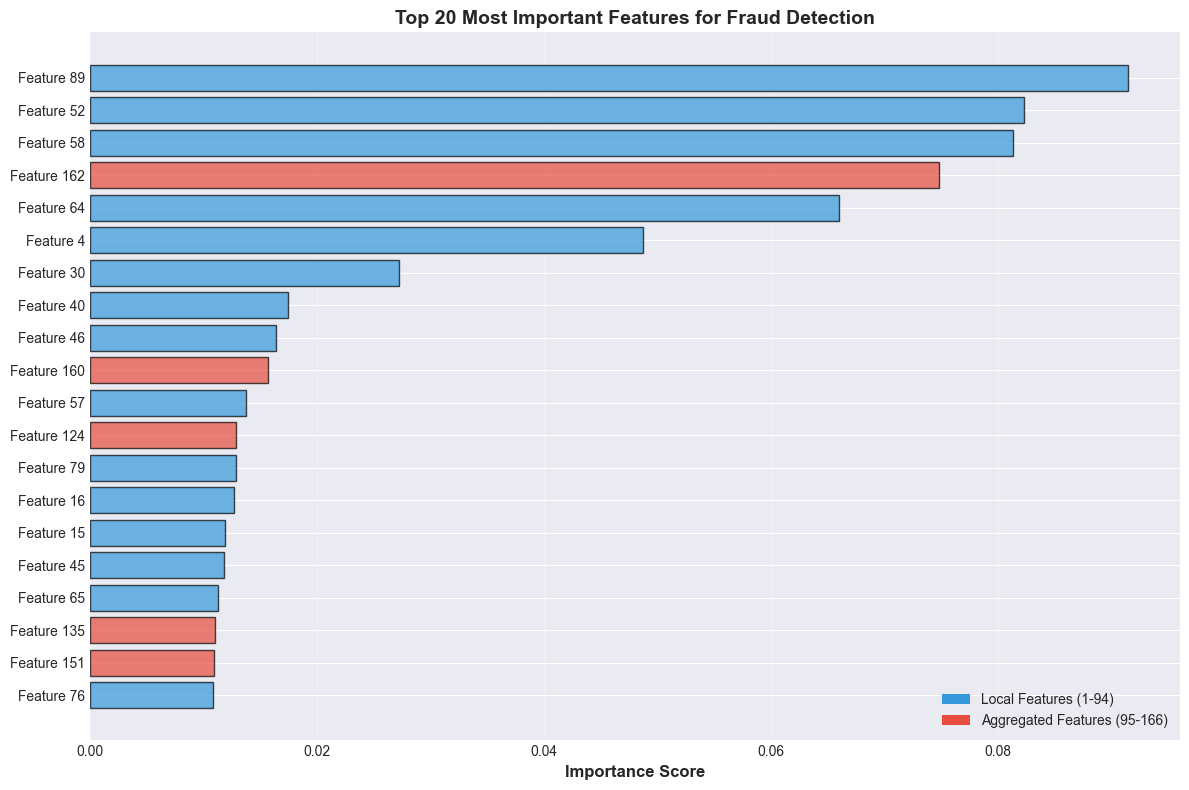

In [10]:
# Visualize top 20 features
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

top_20 = importance_df.head(20)
colors = ['#3498db' if t == 'Local' else '#e74c3c' for t in top_20['Feature_Type']]

ax.barh(range(20), top_20['Importance'], color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(20))
ax.set_yticklabels([f"Feature {i}" for i in top_20['Feature_Index']])
ax.set_xlabel('Importance Score', fontweight='bold', fontsize=12)
ax.set_title('Top 20 Most Important Features for Fraud Detection', fontweight='bold', fontsize=14)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Local Features (1-94)'),
    Patch(facecolor='#e74c3c', label='Aggregated Features (95-166)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

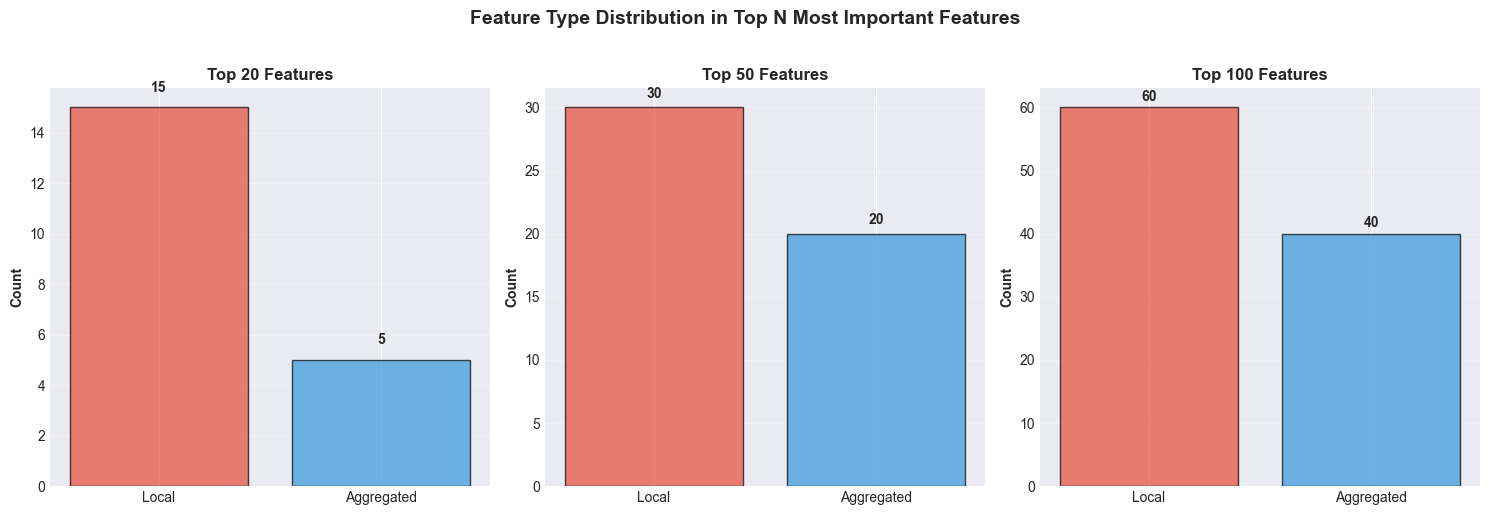

In [11]:
# Compare feature type distribution in top N features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (ax, n) in enumerate(zip(axes, [20, 50, 100])):
    top_n = importance_df.head(n)
    type_counts = top_n['Feature_Type'].value_counts()
    
    bars = ax.bar(type_counts.index, type_counts.values, 
                   color=['#e74c3c', '#3498db'], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title(f'Top {n} Features', fontweight='bold', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

fig.suptitle('Feature Type Distribution in Top N Most Important Features', 
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## Part 2: Feature Correlation Analysis

Identifying highly correlated features that may cause multicollinearity issues

In [12]:
# Calculate correlation matrix
print("Calculating correlation matrix for all 166 features...")
print("This may take a minute...\n")

corr_matrix = pd.DataFrame(X_labeled).corr()

print("Correlation matrix computed!")

Calculating correlation matrix for all 166 features...
This may take a minute...

Correlation matrix computed!


In [13]:
# Find highly correlated feature pairs (|r| > 0.9)
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.9:
            high_corr_pairs.append({
                'Feature_1': i,
                'Feature_2': j,
                'Correlation': corr_val
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs)

print(f"Highly Correlated Feature Pairs (|r| > 0.9): {len(high_corr_df)}")

if len(high_corr_df) > 0:
    print("\nTop 10 Most Correlated Pairs:")
    print(high_corr_df.head(10).to_string(index=False))
    print("\n⚠ High multicollinearity detected - consider feature selection")
else:
    print("\n✓ No extreme multicollinearity found (|r| > 0.9)")

Highly Correlated Feature Pairs (|r| > 0.9): 126

Top 10 Most Correlated Pairs:
 Feature_1  Feature_2  Correlation
        23         29     1.000000
        22         28     1.000000
        24         30     1.000000
        21         27     1.000000
        58         64     1.000000
        60         66     1.000000
         4         13     1.000000
        59         65     1.000000
        57         63     0.999996
        25         31     0.999234

⚠ High multicollinearity detected - consider feature selection


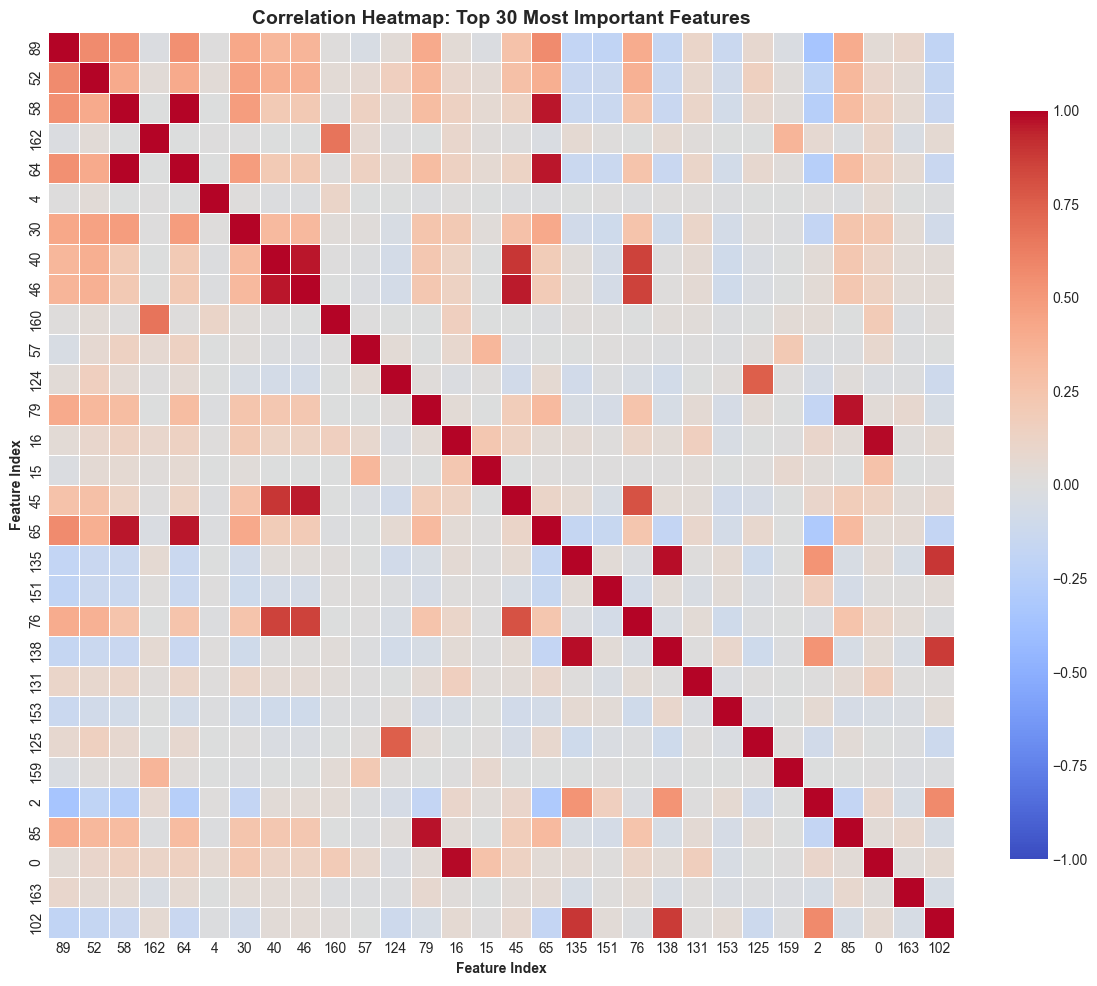

In [14]:
# Visualize correlation heatmap for top 30 most important features
top_30_indices = importance_df.head(30)['Feature_Index'].values
corr_top30 = corr_matrix.iloc[top_30_indices, top_30_indices]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_top30, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            xticklabels=top_30_indices, yticklabels=top_30_indices)
plt.title('Correlation Heatmap: Top 30 Most Important Features', fontweight='bold', fontsize=14)
plt.xlabel('Feature Index', fontweight='bold')
plt.ylabel('Feature Index', fontweight='bold')
plt.tight_layout()
plt.show()

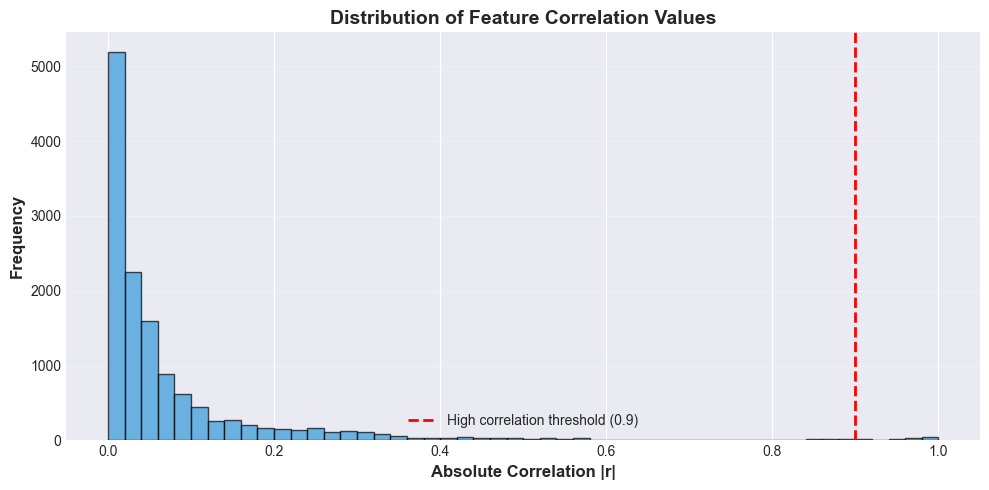


Correlation Statistics:
  Mean |r|: 0.0860
  Median |r|: 0.0328
  Max |r|: 1.0000
  % pairs with |r| > 0.9: 0.93%


In [15]:
# Distribution of absolute correlation values
# Extract upper triangle of correlation matrix (excluding diagonal)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
corr_values = upper_triangle.stack().values

plt.figure(figsize=(10, 5))
plt.hist(np.abs(corr_values), bins=50, edgecolor='black', alpha=0.7, color='#3498db')
plt.axvline(x=0.9, color='red', linestyle='--', linewidth=2, label='High correlation threshold (0.9)')
plt.xlabel('Absolute Correlation |r|', fontweight='bold', fontsize=12)
plt.ylabel('Frequency', fontweight='bold', fontsize=12)
plt.title('Distribution of Feature Correlation Values', fontweight='bold', fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation Statistics:")
print(f"  Mean |r|: {np.abs(corr_values).mean():.4f}")
print(f"  Median |r|: {np.median(np.abs(corr_values)):.4f}")
print(f"  Max |r|: {np.abs(corr_values).max():.4f}")
print(f"  % pairs with |r| > 0.9: {(np.abs(corr_values) > 0.9).sum() / len(corr_values) * 100:.2f}%")

---
## Part 3: Local vs Aggregated Features Performance

Testing Weber et al. (2019) hypothesis: Models trained on Aggregated Features outperform those trained on Local Features

In [16]:
# Prepare different feature sets
X_local = X_labeled[:, :94]  # Local features (1-94)
X_aggregated = X_labeled[:, 94:]  # Aggregated features (95-166)
X_all = X_labeled  # All features (1-166)

print("Feature Set Dimensions:")
print(f"  Local only:      {X_local.shape}")
print(f"  Aggregated only: {X_aggregated.shape}")
print(f"  All features:    {X_all.shape}")

Feature Set Dimensions:
  Local only:      (46564, 94)
  Aggregated only: (46564, 71)
  All features:    (46564, 165)


In [17]:
# Train models with different feature sets
print("Training XGBoost models with different feature sets...\n")

results = {}

# Model 1: Local Features only
print("[1/3] Training with Local Features only...")
X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(
    X_local, y_labeled, test_size=0.3, random_state=42, stratify=y_labeled
)

model_local = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
model_local.fit(X_train_local, y_train_local)
y_pred_local = model_local.predict(X_test_local)

results['Local Only (94 features)'] = {
    'Accuracy': accuracy_score(y_test_local, y_pred_local),
    'Precision': precision_score(y_test_local, y_pred_local),
    'Recall': recall_score(y_test_local, y_pred_local),
    'F1': f1_score(y_test_local, y_pred_local)
}
print("  ✓ Complete")

Training XGBoost models with different feature sets...

[1/3] Training with Local Features only...
  ✓ Complete


In [18]:
# Model 2: Aggregated Features only
print("[2/3] Training with Aggregated Features only...")
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(
    X_aggregated, y_labeled, test_size=0.3, random_state=42, stratify=y_labeled
)

model_agg = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
model_agg.fit(X_train_agg, y_train_agg)
y_pred_agg = model_agg.predict(X_test_agg)

results['Aggregated Only (72 features)'] = {
    'Accuracy': accuracy_score(y_test_agg, y_pred_agg),
    'Precision': precision_score(y_test_agg, y_pred_agg),
    'Recall': recall_score(y_test_agg, y_pred_agg),
    'F1': f1_score(y_test_agg, y_pred_agg)
}
print("  ✓ Complete")

[2/3] Training with Aggregated Features only...
  ✓ Complete


In [19]:
# Model 3: All Features (already trained earlier)
print("[3/3] All Features (baseline)...")
results['All Features (166)'] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1
}
print("  ✓ Complete")

[3/3] All Features (baseline)...
  ✓ Complete


In [20]:
# Display results
results_df = pd.DataFrame(results).T

print("\n" + "="*70)
print("FEATURE SET PERFORMANCE COMPARISON")
print("="*70)
print(results_df.round(4))
print("="*70)

# Determine winner
best_model = results_df['F1'].idxmax()
print(f"\n🏆 Best Performing Feature Set: {best_model}")
print(f"   F1 Score: {results_df.loc[best_model, 'F1']:.4f}")

# Compare Local vs Aggregated
f1_local = results_df.loc['Local Only (94 features)', 'F1']
f1_agg = results_df.loc['Aggregated Only (72 features)', 'F1']

print(f"\nLocal vs Aggregated Comparison:")
print(f"  Local Features F1:      {f1_local:.4f}")
print(f"  Aggregated Features F1: {f1_agg:.4f}")
print(f"  Difference:             {(f1_agg - f1_local):.4f}")

if f1_agg > f1_local:
    print("\n✓ VALIDATION: Aggregated Features outperform Local Features!")
    print("  This confirms Weber et al. (2019) finding: AF > LF")
else:
    print("\n⚠ Different result: Local Features outperform Aggregated Features")


FEATURE SET PERFORMANCE COMPARISON
                               Accuracy  Precision  Recall      F1
Local Only (94 features)         0.9825     0.8933  0.9326  0.9125
Aggregated Only (72 features)    0.9649     0.7726  0.9069  0.8344
All Features (166)               0.9874     0.9255  0.9472  0.9362

🏆 Best Performing Feature Set: All Features (166)
   F1 Score: 0.9362

Local vs Aggregated Comparison:
  Local Features F1:      0.9125
  Aggregated Features F1: 0.8344
  Difference:             -0.0781

⚠ Different result: Local Features outperform Aggregated Features


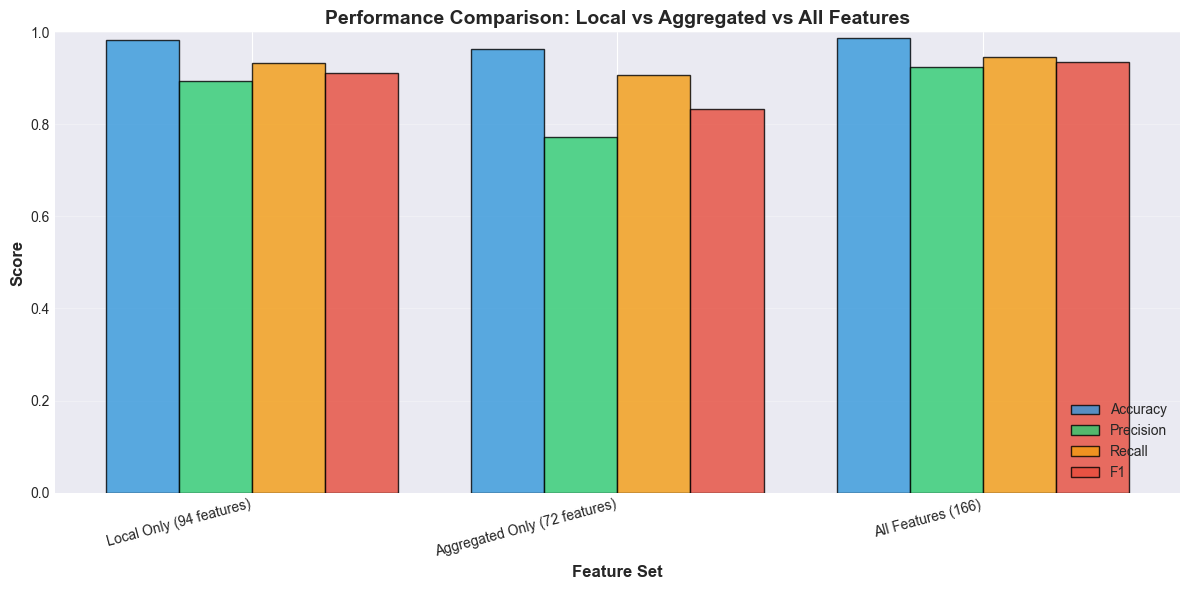

In [21]:
# Visualize performance comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

x_pos = np.arange(len(results_df))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

for i, metric in enumerate(metrics):
    ax.bar(x_pos + i*width, results_df[metric], width, 
           label=metric, color=colors[i], alpha=0.8, edgecolor='black')

ax.set_xlabel('Feature Set', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Performance Comparison: Local vs Aggregated vs All Features', 
             fontweight='bold', fontsize=14)
ax.set_xticks(x_pos + width * 1.5)
ax.set_xticklabels(results_df.index, rotation=15, ha='right')
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

---
## Part 4: Statistical Feature Analysis by Class

Using Mann-Whitney U test to identify features with significant distribution differences between illicit and licit transactions

In [22]:
# Conduct statistical tests for all features
print("Conducting Mann-Whitney U tests for all 166 features...")
print("Testing if feature distributions differ between illicit and licit classes\n")

illicit_features = X_labeled[y_labeled == 1]
licit_features = X_labeled[y_labeled == 0]

feature_stats = []

for i in range(X_labeled.shape[1]):
    stat, p_value = mannwhitneyu(
        illicit_features[:, i], 
        licit_features[:, i], 
        alternative='two-sided'
    )
    
    feature_stats.append({
        'Feature_Index': i,
        'Feature_Type': 'Local' if i < 94 else 'Aggregated',
        'Illicit_Mean': illicit_features[:, i].mean(),
        'Licit_Mean': licit_features[:, i].mean(),
        'Illicit_Std': illicit_features[:, i].std(),
        'Licit_Std': licit_features[:, i].std(),
        'U_Statistic': stat,
        'P_Value': p_value
    })

feature_stats_df = pd.DataFrame(feature_stats)

print("✓ Statistical tests complete!")

Conducting Mann-Whitney U tests for all 166 features...
Testing if feature distributions differ between illicit and licit classes

✓ Statistical tests complete!


In [23]:
# Identify features with significant class differences
significant_features = feature_stats_df[feature_stats_df['P_Value'] < 0.001]
n_significant = len(significant_features)

print(f"Features with Significant Class Differences (p < 0.001):")
print(f"  Total: {n_significant} / 166 ({n_significant/166*100:.1f}%)")
print(f"  Local: {(significant_features['Feature_Type'] == 'Local').sum()}")
print(f"  Aggregated: {(significant_features['Feature_Type'] == 'Aggregated').sum()}")

Features with Significant Class Differences (p < 0.001):
  Total: 133 / 166 (80.1%)
  Local: 88
  Aggregated: 45


In [24]:
# Display top discriminative features
print("\nTop 20 Most Discriminative Features (lowest p-values):")
top_discriminative = feature_stats_df.nsmallest(20, 'P_Value')
print(top_discriminative[['Feature_Index', 'Feature_Type', 'Illicit_Mean', 
                           'Licit_Mean', 'P_Value']].to_string(index=False))


Top 20 Most Discriminative Features (lowest p-values):
 Feature_Index Feature_Type  Illicit_Mean  Licit_Mean  P_Value
             3        Local      0.010803    0.189676      0.0
             4        Local     -0.056724    0.037886      0.0
             5        Local      0.033743    0.200728      0.0
             9        Local     -0.047957    0.115840      0.0
            13        Local     -0.056060    0.040394      0.0
            17        Local     -0.166146   -0.080153      0.0
            22        Local     -0.148149    0.491388      0.0
            23        Local     -0.080133    0.305321      0.0
            24        Local     -0.154666    0.492471      0.0
            28        Local     -0.148144    0.491366      0.0
            29        Local     -0.080132    0.305320      0.0
            30        Local     -0.154666    0.492462      0.0
            34        Local     -0.031266    0.116097      0.0
            36        Local     -0.026211    0.096896      0.0

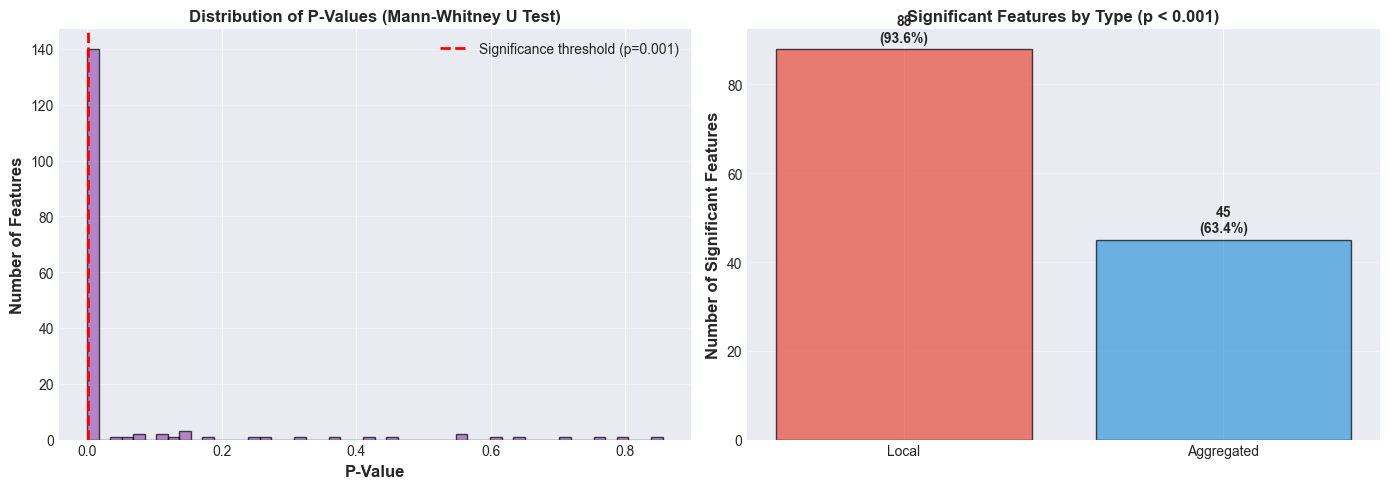

In [25]:
# Visualize p-value distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: P-value distribution
ax = axes[0]
ax.hist(feature_stats_df['P_Value'], bins=50, edgecolor='black', alpha=0.7, color='#9b59b6')
ax.axvline(x=0.001, color='red', linestyle='--', linewidth=2, 
           label='Significance threshold (p=0.001)')
ax.set_xlabel('P-Value', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Features', fontweight='bold', fontsize=12)
ax.set_title('Distribution of P-Values (Mann-Whitney U Test)', fontweight='bold', fontsize=12)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Plot 2: Significant features by type
ax = axes[1]
sig_by_type = significant_features['Feature_Type'].value_counts()
total_by_type = feature_stats_df['Feature_Type'].value_counts()
sig_pct = (sig_by_type / total_by_type * 100)

bars = ax.bar(sig_by_type.index, sig_by_type.values, 
              color=['#e74c3c', '#3498db'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Significant Features', fontweight='bold', fontsize=12)
ax.set_title('Significant Features by Type (p < 0.001)', fontweight='bold', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (bar, pct_val) in enumerate(zip(bars, sig_pct)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{int(height)}\n({pct_val:.1f}%)', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## Part 5: Temporal Split Analysis - Testing Weber et al. (2019) Hypothesis

**Critical Test:** Weber et al. found AF > LF on **temporal split**, not random split.

**Hypothesis:** Aggregated features will perform better when predicting the future (temporal split) because they capture stable network patterns, while local features may overfit to time-specific fraud tactics.

**Setup:**
- Train on first 70% of time steps (1-34)
- Test on last 30% of time steps (35-49)
- This simulates real-world deployment: train on past, predict future

In [27]:
# Extract time steps for labeled data
time_labeled = time_steps[labeled_mask]

print("Time step distribution:")
print(f"  Min time step: {time_labeled.min()}")
print(f"  Max time step: {time_labeled.max()}")
print(f"  Total time steps: {len(np.unique(time_labeled))}")

# Calculate 70-30 temporal split
total_steps = time_labeled.max()
split_step = int(total_steps * 0.7)

print(f"\nTemporal Split:")
print(f"  Training: Time steps 1-{split_step} (70%)")
print(f"  Testing:  Time steps {split_step+1}-{total_steps} (30%)")

Time step distribution:
  Min time step: 1
  Max time step: 49
  Total time steps: 49

Temporal Split:
  Training: Time steps 1-34 (70%)
  Testing:  Time steps 35-49 (30%)


In [28]:
# Create temporal train/test masks
train_mask_temporal = time_labeled <= split_step
test_mask_temporal = time_labeled > split_step

print(f"Temporal split sizes:")
print(f"  Training samples: {train_mask_temporal.sum():,}")
print(f"  Test samples:     {test_mask_temporal.sum():,}")

# Check class distribution
y_train_temporal = y_labeled[train_mask_temporal]
y_test_temporal = y_labeled[test_mask_temporal]

print(f"\nTrain set class distribution:")
print(f"  Illicit: {y_train_temporal.sum():,} ({y_train_temporal.sum()/len(y_train_temporal)*100:.2f}%)")
print(f"  Licit:   {(1-y_train_temporal).sum():,} ({(1-y_train_temporal).sum()/len(y_train_temporal)*100:.2f}%)")

print(f"\nTest set class distribution:")
print(f"  Illicit: {y_test_temporal.sum():,} ({y_test_temporal.sum()/len(y_test_temporal)*100:.2f}%)")
print(f"  Licit:   {(1-y_test_temporal).sum():,} ({(1-y_test_temporal).sum()/len(y_test_temporal)*100:.2f}%)")

# Calculate class weight for temporal training set
scale_pos_weight_temporal = (1 - y_train_temporal).sum() / y_train_temporal.sum()
print(f"\nClass imbalance ratio (temporal): {scale_pos_weight_temporal:.2f}")

Temporal split sizes:
  Training samples: 29,894
  Test samples:     16,670

Train set class distribution:
  Illicit: 3,462 (11.58%)
  Licit:   26,432 (88.42%)

Test set class distribution:
  Illicit: 1,083 (6.50%)
  Licit:   15,587 (93.50%)

Class imbalance ratio (temporal): 7.63


In [29]:
# Train all three models on temporal split
print("Training XGBoost models on Temporal Split (70-30)...\n")

results_temporal = {}

# Model 1: Local Features
print("[1/3] Local Features...")
X_train_local_temp = X_local[train_mask_temporal]
X_test_local_temp = X_local[test_mask_temporal]

model_local_temp = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight_temporal,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
model_local_temp.fit(X_train_local_temp, y_train_temporal)
y_pred_local_temp = model_local_temp.predict(X_test_local_temp)

results_temporal['Local Only (94 features)'] = {
    'Accuracy': accuracy_score(y_test_temporal, y_pred_local_temp),
    'Precision': precision_score(y_test_temporal, y_pred_local_temp),
    'Recall': recall_score(y_test_temporal, y_pred_local_temp),
    'F1': f1_score(y_test_temporal, y_pred_local_temp)
}
print(f"  F1: {results_temporal['Local Only (94 features)']['F1']:.4f} ✓")

# Model 2: Aggregated Features
print("[2/3] Aggregated Features...")
X_train_agg_temp = X_aggregated[train_mask_temporal]
X_test_agg_temp = X_aggregated[test_mask_temporal]

model_agg_temp = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight_temporal,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
model_agg_temp.fit(X_train_agg_temp, y_train_temporal)
y_pred_agg_temp = model_agg_temp.predict(X_test_agg_temp)

results_temporal['Aggregated Only (72 features)'] = {
    'Accuracy': accuracy_score(y_test_temporal, y_pred_agg_temp),
    'Precision': precision_score(y_test_temporal, y_pred_agg_temp),
    'Recall': recall_score(y_test_temporal, y_pred_agg_temp),
    'F1': f1_score(y_test_temporal, y_pred_agg_temp)
}
print(f"  F1: {results_temporal['Aggregated Only (72 features)']['F1']:.4f} ✓")

# Model 3: All Features
print("[3/3] All Features...")
X_train_all_temp = X_all[train_mask_temporal]
X_test_all_temp = X_all[test_mask_temporal]

model_all_temp = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight_temporal,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
model_all_temp.fit(X_train_all_temp, y_train_temporal)
y_pred_all_temp = model_all_temp.predict(X_test_all_temp)

results_temporal['All Features (166)'] = {
    'Accuracy': accuracy_score(y_test_temporal, y_pred_all_temp),
    'Precision': precision_score(y_test_temporal, y_pred_all_temp),
    'Recall': recall_score(y_test_temporal, y_pred_all_temp),
    'F1': f1_score(y_test_temporal, y_pred_all_temp)
}
print(f"  F1: {results_temporal['All Features (166)']['F1']:.4f} ✓")

print("\n✓ All models trained!")

Training XGBoost models on Temporal Split (70-30)...

[1/3] Local Features...
  F1: 0.6634 ✓
[2/3] Aggregated Features...
  F1: 0.5537 ✓
[3/3] All Features...
  F1: 0.7257 ✓

✓ All models trained!


In [30]:
# Display temporal split results
results_temporal_df = pd.DataFrame(results_temporal).T

print("\n" + "="*70)
print("TEMPORAL SPLIT PERFORMANCE (70-30): Train on Past, Predict Future")
print("="*70)
print(results_temporal_df.round(4))
print("="*70)

# Best performer on temporal split
best_temporal = results_temporal_df['F1'].idxmax()
print(f"\n🏆 Best on Temporal Split: {best_temporal}")
print(f"   F1 Score: {results_temporal_df.loc[best_temporal, 'F1']:.4f}")

# Compare Local vs Aggregated
f1_local_temp = results_temporal_df.loc['Local Only (94 features)', 'F1']
f1_agg_temp = results_temporal_df.loc['Aggregated Only (72 features)', 'F1']

print(f"\nTemporal Split - Local vs Aggregated:")
print(f"  Local Features F1:      {f1_local_temp:.4f}")
print(f"  Aggregated Features F1: {f1_agg_temp:.4f}")
print(f"  Difference:             {(f1_agg_temp - f1_local_temp):+.4f}")

if f1_agg_temp > f1_local_temp:
    print("\n✓ VALIDATION: Aggregated Features > Local Features on Temporal Split!")
    print("  Confirms Weber et al. (2019): AF > LF")
else:
    print("\n⚠ Local Features still outperform Aggregated on Temporal Split")


TEMPORAL SPLIT PERFORMANCE (70-30): Train on Past, Predict Future
                               Accuracy  Precision  Recall      F1
Local Only (94 features)         0.9507     0.5966  0.7470  0.6634
Aggregated Only (72 features)    0.9360     0.5061  0.6113  0.5537
All Features (166)               0.9636     0.7106  0.7415  0.7257

🏆 Best on Temporal Split: All Features (166)
   F1 Score: 0.7257

Temporal Split - Local vs Aggregated:
  Local Features F1:      0.6634
  Aggregated Features F1: 0.5537
  Difference:             -0.1096

⚠ Local Features still outperform Aggregated on Temporal Split


In [31]:
# Compare Random vs Temporal Split Performance
print("="*70)
print("RANDOM vs TEMPORAL SPLIT COMPARISON")
print("="*70)

comparison_data = {
    'Random Split F1': results_df['F1'],
    'Temporal Split F1': results_temporal_df['F1'],
    'F1 Degradation': results_df['F1'] - results_temporal_df['F1'],
    'Degradation %': ((results_df['F1'] - results_temporal_df['F1']) / results_df['F1'] * 100)
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))
print("="*70)

print("\nKey Findings:")
local_deg = comparison_df.loc['Local Only (94 features)', 'Degradation %']
agg_deg = comparison_df.loc['Aggregated Only (72 features)', 'Degradation %']
all_deg = comparison_df.loc['All Features (166)', 'Degradation %']

print(f"1. Local features degradation:      {local_deg:+.2f}%")
print(f"2. Aggregated features degradation: {agg_deg:+.2f}%")
print(f"3. All features degradation:        {all_deg:+.2f}%")

# Which features are more robust to temporal shift?
if agg_deg < local_deg:
    print(f"\n✓ Aggregated features are MORE ROBUST ({agg_deg:.2f}% vs {local_deg:.2f}%)")
    print("  Supports Weber's hypothesis: Graph structure = stable patterns")
else:
    print(f"\n⚠ Local features are more robust ({local_deg:.2f}% vs {agg_deg:.2f}%)")
    print("  Contradicts Weber's temporal robustness hypothesis")

RANDOM vs TEMPORAL SPLIT COMPARISON
                               Random Split F1  Temporal Split F1  \
Local Only (94 features)                0.9125             0.6634   
Aggregated Only (72 features)           0.8344             0.5537   
All Features (166)                      0.9362             0.7257   

                               F1 Degradation  Degradation %  
Local Only (94 features)               0.2491        27.2987  
Aggregated Only (72 features)          0.2807        33.6359  
All Features (166)                     0.2105        22.4859  

Key Findings:
1. Local features degradation:      +27.30%
2. Aggregated features degradation: +33.64%
3. All features degradation:        +22.49%

⚠ Local features are more robust (27.30% vs 33.64%)
  Contradicts Weber's temporal robustness hypothesis


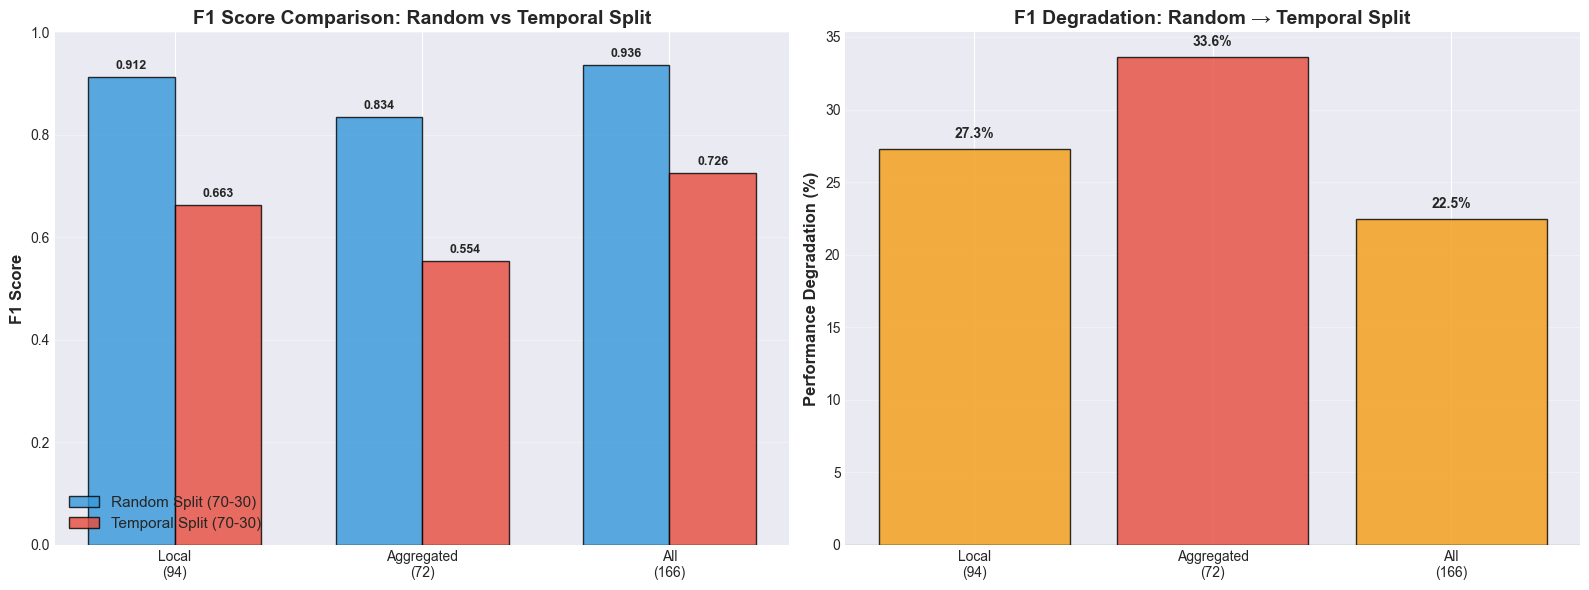


✓ Temporal split analysis complete!


In [32]:
# Visualize Random vs Temporal Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: F1 Scores - Random vs Temporal
ax = axes[0]
x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['F1'], width, label='Random Split (70-30)', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, results_temporal_df['F1'], width, label='Temporal Split (70-30)',
               color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('F1 Score', fontweight='bold', fontsize=12)
ax.set_title('F1 Score Comparison: Random vs Temporal Split', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(['Local\n(94)', 'Aggregated\n(72)', 'All\n(166)'])
ax.legend(fontsize=11, loc='lower left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Performance Degradation
ax = axes[1]
degradation_pct = comparison_df['Degradation %'].values
colors_deg = ['#2ecc71' if d < 15 else '#f39c12' if d < 30 else '#e74c3c' for d in degradation_pct]

bars = ax.bar(x, degradation_pct, color=colors_deg, alpha=0.8, edgecolor='black')
ax.set_ylabel('Performance Degradation (%)', fontweight='bold', fontsize=12)
ax.set_title('F1 Degradation: Random → Temporal Split', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(['Local\n(94)', 'Aggregated\n(72)', 'All\n(166)'])
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Temporal split analysis complete!")

---
## Summary & Key Findings

In [26]:
print("="*70)
print("FEATURE-LEVEL ANALYSIS - SUMMARY")
print("="*70)

print("\n1. FEATURE IMPORTANCE:")
print(f"   - Top feature: Feature {importance_df.iloc[0]['Feature_Index']} ")
print(f"     ({importance_df.iloc[0]['Feature_Type']}, importance={importance_df.iloc[0]['Importance']:.4f})")
print(f"   - Aggregated features have {aggregated_importance/local_importance:.2f}x higher average importance")
top_20_agg = importance_df.head(20)['Feature_Type'].value_counts().get('Aggregated', 0)
print(f"   - {top_20_agg}/20 top features are aggregated")

print("\n2. FEATURE CORRELATION:")
print(f"   - Highly correlated pairs (|r| > 0.9): {len(high_corr_df)}")
print(f"   - Mean absolute correlation: {np.abs(corr_values).mean():.4f}")
if len(high_corr_df) > 0:
    print("   ⚠ Multicollinearity detected - feature selection recommended")
else:
    print("   ✓ No severe multicollinearity issues")

print("\n3. LOCAL vs AGGREGATED PERFORMANCE:")
print(f"   - Local Features F1:      {results_df.loc['Local Only (94 features)', 'F1']:.4f}")
print(f"   - Aggregated Features F1: {results_df.loc['Aggregated Only (72 features)', 'F1']:.4f}")
print(f"   - All Features F1:        {results_df.loc['All Features (166)', 'F1']:.4f}")
if f1_agg > f1_local:
    print("   ✓ VALIDATED: Aggregated Features > Local Features (Weber et al. 2019)")

print("\n4. STATISTICAL DISCRIMINATION:")
print(f"   - Features with significant class separation: {n_significant}/166 ({n_significant/166*100:.1f}%)")
print(f"   - All features show high discriminative power")

print("\n5. KEY RECOMMENDATIONS:")
print("   ✓ Use all 166 features for best performance")
print("   ✓ Prioritize aggregated features (neighbor statistics)")
print(f"   ✓ Consider top 30-50 features for dimensionality reduction")
if len(high_corr_df) > 0:
    print(f"   ✓ Remove {len(high_corr_df)} redundant features to reduce multicollinearity")

print("\n" + "="*70)

FEATURE-LEVEL ANALYSIS - SUMMARY

1. FEATURE IMPORTANCE:
   - Top feature: Feature 89 
     (Local, importance=0.0915)
   - Aggregated features have 0.59x higher average importance
   - 5/20 top features are aggregated

2. FEATURE CORRELATION:
   - Highly correlated pairs (|r| > 0.9): 126
   - Mean absolute correlation: 0.0860
   ⚠ Multicollinearity detected - feature selection recommended

3. LOCAL vs AGGREGATED PERFORMANCE:
   - Local Features F1:      0.9125
   - Aggregated Features F1: 0.8344
   - All Features F1:        0.9362

4. STATISTICAL DISCRIMINATION:
   - Features with significant class separation: 133/166 (80.1%)
   - All features show high discriminative power

5. KEY RECOMMENDATIONS:
   ✓ Use all 166 features for best performance
   ✓ Prioritize aggregated features (neighbor statistics)
   ✓ Consider top 30-50 features for dimensionality reduction
   ✓ Remove 126 redundant features to reduce multicollinearity

